Santeri Hynninen

CASE: F1 EMILIA-ROMAGNAN GP 2024
GOAL: Predict the top 5 drivers for the race

APPROACH

First thoughts: The tracks, cars and drivers are different are changing every time: not that much datapoints
                The track characteristics could have big impact of how well the car and the driver performs
                We should compare the drivers performance to the track characterictics

DATA Sources:    GeoJson data from the most of the tracks: https://github.com/bacinger/f1-circuits/tree/master/circuits
                 Race statistics from: https://github.com/f1db/f1db/

                Final dataframe should be something like
                Year, Driver, Team, Weather(maybe), n x (different track attributes), placement

RESTRICTIONS:   There have been large changes to the cars in season 2022, thus we will use data only from seasons 2022-2024
                Tiremanufacturer is Pirel for every driver

TRACK ATTRIBUTES:       We would like to have the charestics of track - what are these charestics?
                        Note that we dont have to project the geodata because we are looking relative attributes of the data
                        Straights: 
                        Curves:  [over40, over30, over15, avg, stdev, avg_diff, stdev_diff]

HOW SPECIAL CASES ARE HANDELED:
                        Categorial data(engine manufacturer and driver) are one hot encoded: https://en.wikipedia.org/wiki/One-hot
                        (each category value is changed to truth column)

                        NAs(only in position column when the driver did not finish)
                        These values are removed because the prediction is impossible
                

In [176]:
import pandas as pd
import numpy as np
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC


from sklearn.model_selection import GridSearchCV

import seaborn as sns

In [177]:
FROM_YEAR = 2000

track_type = {'ROAD':0,
              'STREET':1,
              'RACE':2}

In [178]:
df = pd.read_csv(r'data\f1db-races-race-results.csv')
df = df[['raceId','year','positionNumber', 'driverId']]
df = df[~df['positionNumber'].isna()]
race_results = df

df = pd.read_csv(r'data\f1db-races-qualifying-1-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying1= df

df = pd.read_csv(r'data\f1db-races-qualifying-2-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying2= df

df = pd.read_csv(r'data\f1db-races-qualifying-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_qualifying3= df


df = pd.read_csv(r'data\f1db-races-free-practice-1-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice1= df

df = pd.read_csv(r'data\f1db-races-free-practice-2-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice2= df

df = pd.read_csv(r'data\f1db-races-free-practice-3-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice3= df

df = pd.read_csv(r'data\f1db-races-free-practice-4-results.csv')
df = df[['raceId','positionNumber','driverId',"gapMillis"]]
df['gapMillis'] = df['gapMillis'].fillna(0)
race_practice4= df

df = pd.read_csv(r'data\f1db-races-sprint-qualifying-results.csv')
df = df[['raceId','positionNumber','driverId']]
race_sprint_q= df

df = pd.read_csv(r'data\f1db-races-sprint-race-results.csv')
df = df[['raceId','positionNumber','driverId']]
race_sprint= df

df = pd.read_csv(r'data\f1db-races-pit-stops.csv')
df = df[["raceId","driverId","stop","timeMillis"]]
pit_stops= df

df = pd.read_csv(r'data\f1db-races.csv')
df = df[['id','courseLength', "circuitType"]]
df['circuitType'] = df['circuitType'].apply(lambda x: track_type[x])
race_tracks = df


df = pd.read_csv(r'data\f1db-drivers.csv')
df = df[["id","bestChampionshipPosition","totalChampionshipWins","totalRaceWins","totalPodiums","totalPolePositions","totalFastestLaps",]]
df['driver_index'] = df.index + 1
df['bestChampionshipPosition'] = df['bestChampionshipPosition'].fillna(30)
driver_data = df

driver_data

,id,bestChampionshipPosition,totalChampionshipWins,totalRaceWins,totalPodiums,totalPolePositions,totalFastestLaps,driver_index
0,adderly-fong,30.0,0,0,0,0,0,1
1,adolf-brudes,30.0,0,0,0,0,0,2
2,adolfo-schwelm-cruz,30.0,0,0,0,0,0,3
3,adrian-campos,30.0,0,0,0,0,0,4
4,adrian-sutil,9.0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...
896,yuji-ide,25.0,0,0,0,0,0,897
897,yuki-tsunoda,14.0,0,0,0,0,1,898
898,yves-giraud-cabantous,14.0,0,0,0,0,0,899
899,zak-osullivan,30.0,0,0,0,0,0,900


In [179]:
df = pit_stops.groupby(["raceId","driverId"],as_index=False).mean()
pit_stops = df


df = race_results.sort_values(by='raceId', axis=0)
df['rolling'] = df.groupby("driverId",group_keys=False)['positionNumber'].rolling(window=5, min_periods=1).mean().values

df['streak_s'] = df.groupby('driverId',group_keys=False)['positionNumber'].apply(lambda x: x.ne(x.shift()))
df['streak_id'] = df.groupby('driverId',group_keys=False)['streak_s'].cumsum()
df['streak_counter'] = df.groupby(['streak_id', 'driverId'],group_keys=False).cumcount() + 1

df = df.drop(['streak_s', 'streak_id'], axis=1)
race_results = df

In [180]:

df = pd.merge(race_results, race_practice1, how='left', on=['raceId','driverId'], suffixes=(None, '_practice1'))
df = pd.merge(df, race_practice2, how='left', on=['raceId','driverId'], suffixes=(None, '_practice2'))
df = pd.merge(df, race_practice3, how='left', on=['raceId','driverId'], suffixes=(None, '_practice3'))
df = pd.merge(df, race_qualifying3, how='left', on=['raceId','driverId'], suffixes=('_race', '_qualifying3'))
df = pd.merge(df, race_tracks, how='left', left_on=['raceId'], right_on=['id'],suffixes=(None, '_track'))
df = pd.merge(df, race_sprint_q, how='left', on=['raceId','driverId'],suffixes=(None, '_sprint_q'))
df = pd.merge(df, race_sprint, how='left', on=['raceId','driverId'],suffixes=(None, '_sprint'))
df = pd.merge(df, pit_stops, how='left', on=['raceId','driverId'],suffixes=(None, '_pitstops'))
df = df.drop('id', axis=1)
df = pd.merge(df, driver_data, how='left', left_on='driverId', right_on='id',suffixes=(None, '_driver'))
df =df[df['year'] >=FROM_YEAR]
df = df.drop('id', axis=1)

df.sort_values(by=['positionNumber_race', 'positionNumber_practice1', 'positionNumber_practice2', 'positionNumber_practice3', 'positionNumber_qualifying3'], axis=0, inplace=True)
df = df.ffill(axis=1)

print(df.isna().sum())
df['positionNumber_race'] =df['positionNumber_race'].apply(lambda x: int(x))


position_columns = ['positionNumber_race', 'positionNumber_practice1', 'positionNumber_practice2', 
                    'positionNumber_practice3', 'positionNumber_qualifying3',
                    'positionNumber', 'positionNumber_sprint']

df['top5'] = df['positionNumber_race'] < 6
df['top5'] = df['top5'].astype(int)
historic_performance = df.sort_values(by='raceId')

historic_performance.tail()

raceId                        0
year                          0
positionNumber_race           0
driverId                      0
rolling                       0
streak_counter                0
positionNumber_practice1      0
gapMillis_race                0
positionNumber_practice2      0
gapMillis_practice2           0
positionNumber_practice3      0
gapMillis_practice3           0
positionNumber_qualifying3    0
gapMillis_qualifying3         0
courseLength                  0
circuitType                   0
positionNumber                0
positionNumber_sprint         0
stop                          0
timeMillis                    0
bestChampionshipPosition      0
totalChampionshipWins         0
totalRaceWins                 0
totalPodiums                  0
totalPolePositions            0
totalFastestLaps              0
driver_index                  0
dtype: int64


,raceId,year,positionNumber_race,driverId,rolling,streak_counter,positionNumber_practice1,gapMillis_race,positionNumber_practice2,gapMillis_practice2,...,stop,timeMillis,bestChampionshipPosition,totalChampionshipWins,totalRaceWins,totalPodiums,totalPolePositions,totalFastestLaps,driver_index,top5
15670,1107,2024,16,valtteri-bottas,5.666667,1,17.0,1041.0,1041.0,1041.0,...,1.5,23247.5,2.0,0,10,67,20,19,872,0
15676,1107,2024,10,esteban-ocon,11.0,1,9.0,568.0,568.0,568.0,...,1.0,22663.0,8.0,0,1,3,0,0,264,0
15675,1107,2024,11,nico-hulkenberg,10.8,1,13.0,719.0,719.0,719.0,...,1.5,22771.0,7.0,0,0,0,1,2,648,0
15684,1107,2024,1,lando-norris,12.8,1,16.0,900.0,900.0,900.0,...,1.0,22041.0,6.0,0,1,16,1,6,539,1
15683,1107,2024,2,max-verstappen,11.6,1,1.0,0.0,0.0,0.0,...,1.0,22187.0,1.0,3,58,103,38,32,606,1


In [181]:
#sns.pairplot(historic_performance)
#plt.show()

In [182]:
#Training and test sets
sc = MinMaxScaler()
df = historic_performance.drop(['raceId', 'driverId', 'year'], axis=1)
x1, y1 = df.drop(['positionNumber_race', 'top5'], axis=1), df['positionNumber_race']
x2, y2 = df.drop(['positionNumber_race', 'top5'], axis=1), df['top5']

x1 = pd.DataFrame(sc.fit_transform(x1), columns=x1.columns)
x_train, x_test, y_train, y_test = train_test_split(x1, y1, train_size=0.8)
x_train.head().T



,3634,3278,7059,2552,4890
rolling,0.329032,0.012903,0.200000,0.322581,0.212903
streak_counter,0.000000,0.000000,0.000000,0.000000,0.000000
positionNumber_practice1,0.576923,0.000000,0.076923,0.038462,0.230769
gapMillis_race,0.006799,0.000000,0.000595,0.000282,0.002337
positionNumber_practice2,0.000341,0.000426,0.000313,0.000256,0.000028
gapMillis_practice2,0.005686,0.008728,0.006279,0.003918,0.000000
positionNumber_practice3,0.000007,0.000009,0.000007,0.000002,0.000050
gapMillis_practice3,0.001157,0.000509,0.000699,0.000000,0.000000
positionNumber_qualifying3,0.000943,0.000189,0.000189,0.000283,0.000189
gapMillis_qualifying3,0.070057,0.004874,0.000321,0.016256,0.004777


In [183]:
def visualize(y_test, y_pred, label):
    score_df = pd.DataFrame({'test': y_test, 'pred': y_pred, 'diff':y_test-y_pred})
    agg_df = score_df.groupby(['test', 'pred']).size().reset_index(name='count')
    sns.scatterplot(x='test', y='pred', size='count', data=agg_df)
    x_values = np.linspace(agg_df['test'].min(), agg_df['test'].max(), 10)
    plt.plot(x_values, x_values, color='red', linestyle='-')
    plt.title(label)
    plt.show()

def top5_score(y_true, y_pred):
    positions = [1, 2, 3, 4, 5]
    f1_positions = [f1_score(y_true == pos, y_pred == pos) for pos in positions]
    norm_f1_positions  = sum(f1_positions ) / len(positions)
    return norm_f1_positions

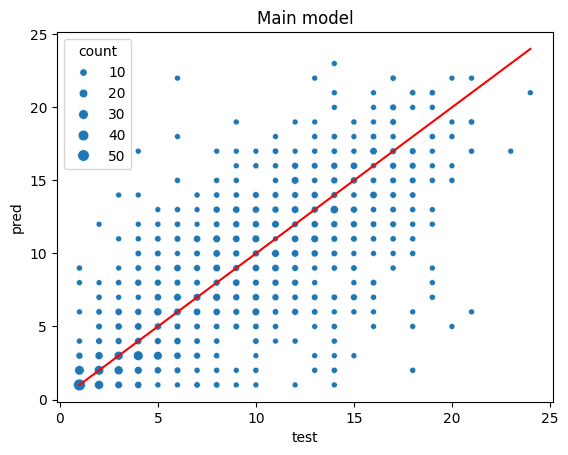

Accuracy of ensembled model: 0.1402359108781127
Custom top5 score: 0.24958028935600102


c:\Users\hynni\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-Val score: 0.14353754648836614


In [184]:
classifiers = [
    ("DecisionTree", DecisionTreeClassifier()),
    ("RandomForest", RandomForestClassifier()),
    ("ExtraTreesClassifier", ExtraTreesClassifier()),
    ("GradientBoosting", GradientBoostingClassifier()),
    ("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis())
]
    
models = OneVsRestClassifier(estimator=GradientBoostingClassifier())
models.fit(x_train, y_train)
y_pred = models.predict(x_test)
visualize(y_test, y_pred, label='Main model')
print("Accuracy of ensembled model:",accuracy_score(y_test, y_pred))
print("Custom top5 score:",top5_score(y_test, y_pred))
print("Cross-Val score:", cross_val_score(models, x_train, y_train, cv=5).mean())




In [185]:
scores = {}
for name, model in models.named_estimators_.items():
        y_pred = model.predict(x_test)
        scores[name] = accuracy_score(y_test, y_pred)
        visualize(y_test, y_pred, label=name)
        print(name, accuracy_score(y_test, y_pred))
        #print("Cross-Val score:", cross_val_score(model, x_train, y_train, cv=5).mean())

AttributeError: 'OneVsRestClassifier' object has no attribute 'named_estimators_'

In [ ]:
params = {
    'DecisionTree__max_depth': [10, 20],
    'RandomForest__max_depth': [5, 10],
    'ExtraTreesClassifier__max_depth': [5, 10],
    'GradientBoosting__learning_rate': [0.1, 0.05],
    'GradientBoosting__max_depth': [3, 5]
}
#'LinearDiscriminantAnalysis__solver': ['svd', 'lsqr', 'eigen'],
#'LinearDiscriminantAnalysis__shrinkage': [None, 'auto']

#grid = GridSearchCV(estimator=models, param_grid=params, cv=5, scoring=make_scorer(top5_score))
#grid = grid.fit(x_train, y_train)
#best_model = grid.best_estimator_
best_model = models
y_pred = best_model.predict(x_test)
print("Accuracy of ensembled model:",accuracy_score(y_test, y_pred))
print("Custom top5 score:",top5_score(y_test, y_pred))
print("Cross-Val score:", cross_val_score(best_model, x_train, y_train, cv=4).mean())

Accuracy of ensembled model: 0.15161290322580645
Custom top5 score: 0.27150701054771575
Cross-Val score: 0.12903225806451613


In [ ]:
#Dumping the model so we can recreate same outcome and reduce running time

from joblib import dump, load
dump(best_model, 'model.joblib') 


['model.joblib']

In [ ]:
best_model = load('model.joblib')


In [ ]:
#Creating excel to manually set data from the oncoming race
df = historic_performance[historic_performance['raceId'] == 1107].drop(['top5', 'driverId','positionNumber_race','raceId','year'], axis=1)
df.to_excel('parameterSetting.xlsx')


In [ ]:
imolaGP = pd.read_excel('parameterSetting.xlsx', index_col=0)
imolaGP

,driverNumber,rolling,streak_counter,positionNumber_practice1,gapMillis_race,positionNumber_practice2,gapMillis_practice2,positionNumber_practice3,gapMillis_practice3,positionNumber_qualifying3,gapMillis_qualifying3,courseLength,circuitType,positionNumber,positionNumber_sprint,stop,timeMillis
15682,16,11.400000,1,20,3504,3504,3504,3504,3504,2,141,5.412,1,2,2,1.0,21825.0
15675,27,10.800000,1,13,719,719,719,719,719,9,905,5.412,1,10,7,1.5,22771.0
15680,55,13.200000,2,3,116,116,116,116,116,3,214,5.412,1,5,5,1.0,22805.0
15678,63,14.000000,1,4,189,189,189,189,189,7,826,5.412,1,11,12,1.0,22800.0
15677,44,13.500000,1,7,417,417,417,417,417,8,866,5.412,1,12,16,1.0,22107.0
15687,20,15.600000,1,12,594,594,594,594,594,19,0,5.412,1,14,18,2.0,27908.0
15684,4,12.800000,1,16,900,900,900,900,900,5,353,5.412,1,9,9,1.0,22041.0
15679,22,12.750000,1,8,461,461,461,461,461,10,951,5.412,1,15,8,1.0,22153.0
15683,1,11.600000,1,1,0,0,0,0,0,1,0,5.412,1,1,1,1.0,22187.0
15671,3,6.000000,1,11,583,583,583,583,583,18,0,5.412,1,4,4,1.0,22540.0


In [ ]:
result_df = pd.DataFrame(best_model.predict(imolaGP))

result_df

,0
0,12
1,12
2,12
3,12
4,12
5,13
6,12
7,12
8,11
9,13
